# CV Lab 6

#### Student number: 1717212

---

In [76]:
import cv2 as cv
from glob import glob
import imageio as iio
import json
import math
import matplotlib.pyplot as plt
%matplotlib inline
import mpmath
from natsort import natsorted
import numpy as np
import PIL
from pathlib import Path
import scipy.stats
import seaborn as sns
import skimage
from skimage import img_as_float32
from skimage.color import rgb2gray, rgb2hsv
from sklearn.neighbors import NearestNeighbors

Load the images and masks

In [77]:
# load images and masks
path_pairs = list(zip(
    natsorted(glob('./puzzle_corners_1024x768/images-1024x768/*.png')),
    natsorted(glob('./puzzle_corners_1024x768/masks-1024x768/*.png')),
))

imgs = np.array([img_as_float32(iio.imread(ipath)) for ipath, _ in path_pairs])
msks = np.array([img_as_float32(iio.imread(mpath)) for _, mpath in path_pairs])

---

## 1 Find Contours

#### Question 1.1

In [78]:
def get_puzzle_contour(mask):
    contours, _ = cv.findContours(mask.astype(np.uint8), cv.RETR_LIST, cv.CHAIN_APPROX_SIMPLE)
    contours = sorted(contours, key=cv.contourArea, reverse=True) # sort by contour area
    return contours[0]

Get contours for all puzzle pieces

In [79]:
cntrs = [] # contours array
for msk in msks:
    cntrs.append(get_puzzle_contour(msk))

#### Question 1.2

In [80]:
def get_clockwise_contour(contour):
    area = cv.contourArea(contour, oriented=True)
    if area < 0:
        return contour[::-1]
    return contour

Make all contours clockwise

In [81]:
for i, cntr in enumerate(cntrs):
    cntrs[i] = get_clockwise_contour(cntr)

#### Question 1.3

cv.findContours

*[Read Topological structural analysis of digitized binary images by border following]*

cv.contourArea

*[Read https://mathinsight.org/greens_theorem_find_area#:%7E:text=We%20can%20parametrized%20it%20in,dt%3D%CF%80r2.]*

#### Question 1.4

Helper function to get images with contours plotted.

In [82]:
def plotContour(img, cntr):
    tmp = imgs[i].copy() # copy image since cv.drawContours modifies the image passed to it
    cntrd = cv.drawContours(tmp, [cntr], 0, (0, 1, 0), 3)
    
    return cntrd

Plot contours

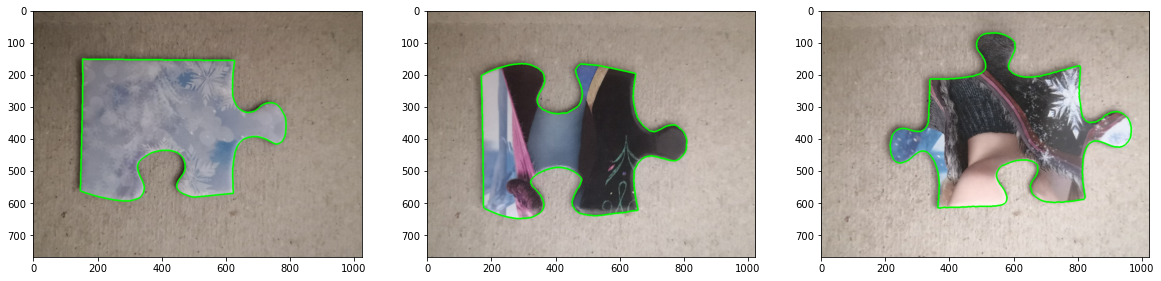

In [83]:
fig = plt.figure(figsize=(20, 12))
for i in range(3):
    fig.add_subplot(1, 3, i+1)
    cntrd = plotContour(imgs[i], cntrs[i]) # get image contours
    
    plt.imshow(cntrd)

---

## 2 Shape Models

### 2.1 Extract Sides

#### Question 2.1.1

In [84]:
names = None
corner_ratios = None

with open("puzzle_corners_1024x768/corners.json", mode="r") as f:
    names, corner_ratios = json.load(f)

crnrs = np.array(corner_ratios) * [imgs[0].shape[1], imgs[0].shape[0]]

#### Question 2.1.2

In [85]:
def extract_sides(contour, corners):
    corner_indices = []
    for crnr in corners:
        dists = np.linalg.norm(contour - crnr, axis=-1) # get distances between the corner and each point in the contour
        corner_indices.append(np.argmin(dists))
    
    corner_indices = sorted(corner_indices)
    
    sides = []
    for i in range(len(corner_indices) - 1): # iterate over all indices except for the last one
        sides.append(contour[corner_indices[i]:corner_indices[i+1] + 1]) # include both corners
    sides.append(np.concatenate((contour[corner_indices[-1]:], contour[0:corner_indices[0]+1]))) # the last side is made up of contour points from the last corner to the end and from the first point to the first corner

    
    return sides

Get sides for every puzzle piece

In [86]:
sides = []
for i, cntr in enumerate(cntrs):
    sides.append(extract_sides(cntr, crnrs[i]))  # each corner index corresponds to the index of its image's contour

#### Question 2.1.3

Helper function to get images with sides and corners plotted

In [87]:
def plotSides(img, sides, crnrs):
    tmp = img.copy()
    clrs = [(1,0,0), (0,1,0), (0,0.250980392,1), (1,0.752941176,0)] # colours for the four sides
    
    for crnr in crnrs: # plot corners
        cntr = [round(crnr[0]), round(crnr[1])]
        cv.circle(tmp, cntr, 15, (1, 1, 1), 15)
    
    for i, side in enumerate(sides): # plot sides
        cv.polylines(tmp, [side], False, clrs[i], 3) # use polylines since drawContours closed the contour plots
    
    return tmp

Plot sides and corners

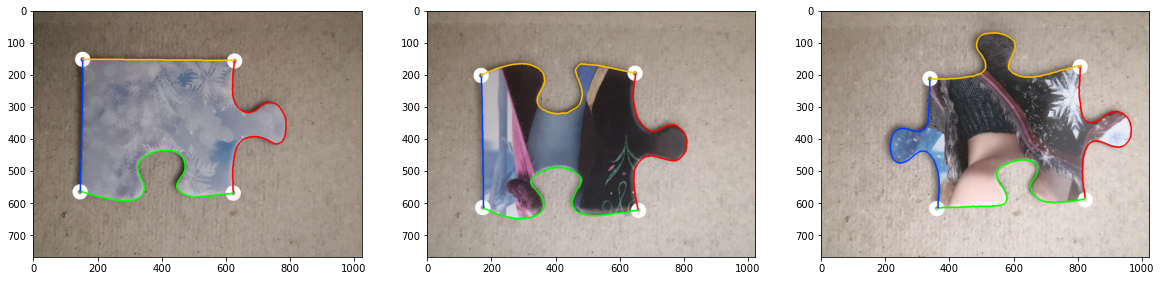

In [88]:
fig = plt.figure(figsize=(20, 12))
for i in range(3):
    fig.add_subplot(1, 3, i+1)
    plotted = plotSides(imgs[i], sides[i], crnrs[i]) # get side and corner plots
    
    plt.imshow(plotted)

### 2.2 Normalise Sides

#### Question 2.2.1

In [89]:
def transform_puzzle_side(contour):
    side = contour.copy().astype(float)
    
    means = np.array([side[0], side[-1]]).mean(axis=0) # mean of the two end points; used for translation
    
    line = side[-1][0] - side[0][0] # line from last point to first point
    lineDist = np.linalg.norm(line)
    
    angle = np.arctan2(line[1], line[0]) * 180 / np.pi # store angle in degrees
    angle = round((angle + 180) / 90) * 90 # round angle to the nearest 90
    
    # translation, scaling
    side = (2 / lineDist) * (side - means)
    
    
    # rotation (note: do nothing to a side whose orientation is 180 degrees)
    if angle in [0, 360]: # facing down, first point pointing to the right
        
        # rotate by 180 degrees
        rot = np.array([[np.cos(np.pi), np.sin(np.pi)], [-np.sin(np.pi), np.cos(np.pi)]]) # rotation matrix
        for i, point in enumerate(side): # rotate points individually
            side[i] = [rot @ point[0]]
        
    elif angle == 90: # facing left, first point pointing down
        
        # rotate by 90 degrees clockwise
        rot = np.array([[np.cos(np.pi / 2), np.sin(np.pi / 2)], [-np.sin(np.pi / 2), np.cos(np.pi / 2)]])
        for i, point in enumerate(side):
            side[i] = [rot @ point[0]]
        
    elif angle == 270: # facing right, first point pointing up
        
        # rotate by 90 degrees anti-clockwise
        rot = np.array([[np.cos(np.pi / 2), -np.sin(np.pi / 2)], [np.sin(np.pi / 2), np.cos(np.pi / 2)]])
        for i, point in enumerate(side):
            side[i] = [rot @ point[0]]
    
    
    return side

Normalise all sides

In [90]:
normalised = []
for puzzle_sides in sides:
    onePiece = [] # store normalised sides of one piece
    
    for side in puzzle_sides: # normalise sides for one puzzle piece
        onePiece.append(transform_puzzle_side(side))
        
    normalised.append(onePiece)

#### Question 2.2.2

In [91]:
def even_spaced_contour(contour, num_points=64):
    # construct A
    lengths = []
    for i in range(len(contour) - 1):
        lengths.append(np.linalg.norm(contour[i + 1] - contour[i])) # append between the current point and the next point
        
    a = np.cumsum(lengths)
    a = np.concatenate((np.array([0]), a)) # prepend a 0 to a
    a /= a[-1]
    
    anew = np.linspace(0, 1, num_points)
    
    x = contour[:, :, 0].reshape(len(contour)).copy()
    y = contour[:, :, 1].reshape(len(contour)).copy()
    
    xInterp = np.interp(anew, a, x)
    yInterp = np.interp(anew, a, y)
    
    cntrIntrp = np.dstack((xInterp, yInterp)).reshape(len(xInterp), 1, 2) # zip x and y and reshape to similar dimensions to contour
    
    return cntrIntrp

Interpolate all sides

In [92]:
interped = [] # interpolated
for normed in normalised:
    onePiece = [] # store interpolated sides of one piece
    for side in normed:
        onePiece.append(even_spaced_contour(side))
    interped.append(onePiece)

#### Question 2.2.3

Part 1

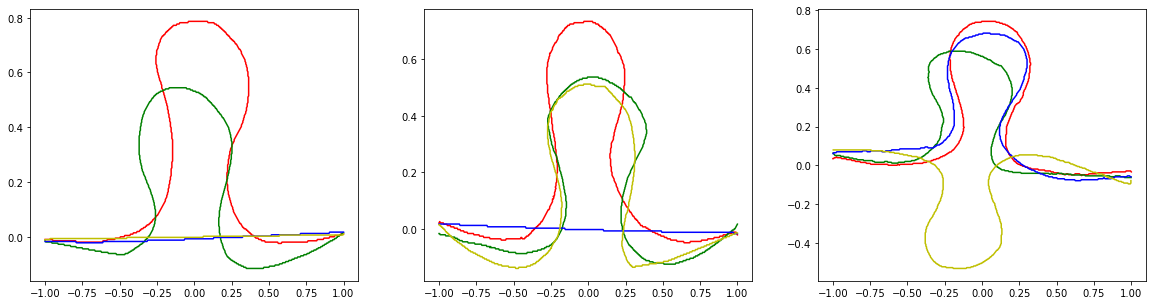

In [93]:
fig = plt.figure(figsize=(20, 5))
clrs = ['r', 'g', 'b', 'y'] # colours for each plotted side; red, green, blue, yellow

for i in range(3):
    fig.add_subplot(1, 3, i+1)
    for j, side in enumerate(normalised[i]):
        x = side[:, 0, 0] # extract x and y from side
        y = side[:, 0, 1]

        plt.plot(x, y, clrs[j])

Part 2

In [94]:
def plotSides2(img, sides):
    tmp = img.copy()
    clrs = [(1,0,0), (0,1,0), (0,0.250980392,1), (1,0.752941176,0)] # colours for the four sides
    
    for i, side in enumerate(sides): # plot sides
        cv.polylines(tmp, [side], False, clrs[i], 3) # use polylines since drawContours closed the contour plots
    
    return tmp

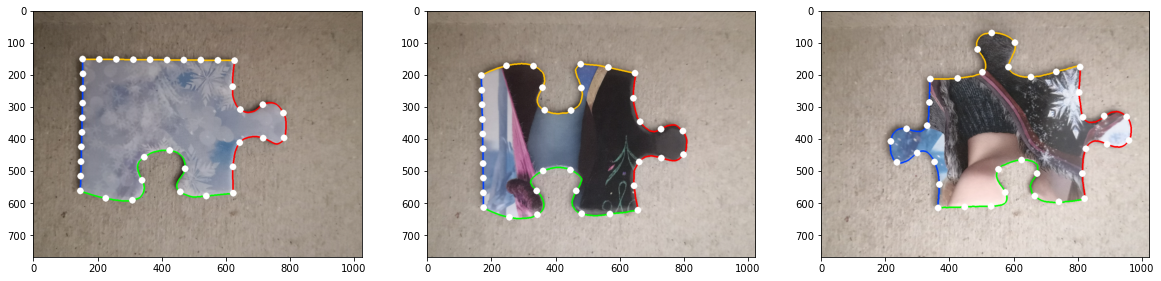

In [95]:
fig = plt.figure(figsize=(20, 8))
for i in range(3):
    sidesMin = [] # store 10 point side contours
    for side in sides[i]:
        sidesMin.append(even_spaced_contour(side, 10))
        
    plotted = plotSides2(imgs[i], sides[i]) # plot sides and corners
    
    for sideMin in sidesMin: # plot corners
        for point in sideMin:
            cntr = [round(point[0][0]), round(point[0][1])] # remember to double check why this is being rounded
            cv.circle(plotted, cntr, 5, (1, 1, 1), 10)
    
    fig.add_subplot(1, 3, i+1)
    plt.imshow(plotted)

---

## 3 Match Shape Models

#### Question 3.1

In [96]:
def is_flat_side(contour, min_ratio=0.9):
    tmp = contour.astype("float32") # cv.arcLength requires floats to be 32 bits in length
    
    cont_dist = np.linalg.norm(tmp[-1] - tmp[0])
    cont_len = cv.arcLength(tmp, closed=False)
    
    if cont_dist/cont_len >= min_ratio:
        return True
    
    return False

#### Question 3.2

In [97]:
nonFlats = []
indices = []
for i, piece in enumerate(interped):
    for j, side in enumerate(piece):
        if not is_flat_side(side):
            nonFlats.append(side)
            indices.append((i, j)) # puzzle piece index then side index

#### Question 3.3

In [118]:
t = np.array(nonFlats)
t.shape
# # assuming sides has a shape of (-1, num_points, 2)
# rotated_sides = (sides * (-1, -1))[:, ::-1, :]
# # TODO: flatten both arrays of side contours into arrays of features
# knn = NearestNeighbors(n_neighbors=1, algorithm="brute")
# knn = knn.fit(rotated_side_features)
# distances, indices = knn.kneighbors(side_features)

(164, 64, 1, 2)